In [1]:
# Calling libraries:
from __future__ import division
%matplotlib inline
import numpy as np, time, matplotlib.pyplot as plt, numpy.random as npr, pystan as ps, pickle
from pylab import plot, show, legend
from time import time
from scipy.stats import *
from tqdm import trange
from functions import *
#import statsmodels.api as sm
import multiprocessing
import arviz as az
import random
import os
import pathlib
#multiprocessing.set_start_method("fork")

INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [2]:
# helper functions
def generate_Y(X, T, alph, b, c):
    y = np.zeros(T).astype(int)
    prob = np.zeros(T)

    for t in range(p) :
        prob[t] = 1/(1+np.exp(-(c+X[t].dot(b)))) 
        y[t] = npr.binomial(n=1,p=prob[t],size=1)
    for t in np.arange(p+1,T) :
        prob[t] = 1/(1+np.exp(-(c+alph.dot(y[(t-p):t])+X[t].dot(b)))) 
        y[t] = npr.binomial(n=1,p=prob[t],size=1)
    return prob, y

def cal_ess(prob):
    samp_dict = {'prob' : prob}
    data = az.from_dict(posterior=samp_dict)
    ess = az.ess(data)
    return ess['prob'].data

In [3]:
random.seed(190)
sym_param = lambda entry, p : np.array([entry] * (p // 2) + [0] + [-entry] * (p // 2)) if p % 2 != 0 else np.array([entry] * (p // 2) + [-entry] * (p // 2))
same_param = lambda entry, p: np.array([entry] * p)
p = 5
T = 10_000
alph = same_param(0.2, p)
prob = np.zeros(T)
c = -0.1
q = 5
b = sym_param(0.5, q)
alph_entries = [0.05, 0.25, 0.5]
n_exp = len(alph_entries)

In [4]:
alphs = np.array([same_param(alph,p) for alph in alph_entries])
alphs,b

(array([[0.05, 0.05, 0.05, 0.05, 0.05],
        [0.25, 0.25, 0.25, 0.25, 0.25],
        [0.5 , 0.5 , 0.5 , 0.5 , 0.5 ]]),
 array([ 0.5,  0.5,  0. , -0.5, -0.5]))

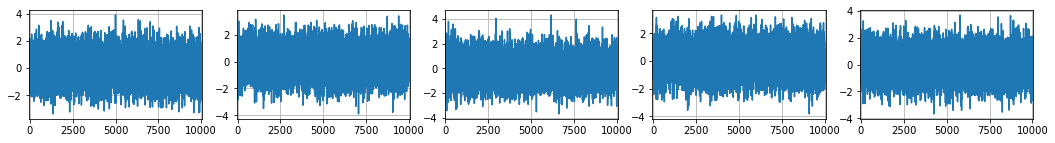

In [5]:
# plot X, use the same X
X = generate_X(T, q)
f = plt.figure(figsize=(18,2))
for i in range(q) :
    plt.subplot(1,q,i+1)
    plt.plot(X[:,i])
    plt.xlim(-0.005*T,1.005*T)
    plt.grid(True)

In [6]:
prob, y = generate_Y(X, T, alph, b, c)
datas = {}
for i in range(n_exp):
    alph = same_param(alph_entries[i],p)
    alph_str = str(alph[0])
    prob, y = generate_Y(X, T, alph, b, c)
    datas[alph_str] = {}
    # save datas
    datas[alph_str]['prob'] = prob
    datas[alph_str]['y'] = y
    datas[alph_str]['alpha'] = alph
    datas[alph_str]['b'] = b
    datas[alph_str]['c'] = c
    datas[alph_str]['X'] = X
    print("alph is " +alph_str+f", ESS ratio is {cal_ess(prob) / T}")

alph is 0.05, ESS ratio is 0.8155490607556611
alph is 0.25, ESS ratio is 0.43650172832188383
alph is 0.5, ESS ratio is 0.2966432757955168


In [10]:
#os.mkdir('multi_sims')
file = open("multiple_sims/datas.pkl", "wb")
pickle.dump(datas, file)
file.close()

In [11]:
# run the simulation pipeline here
sm = ps.StanModel(file="model_binaryAR.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9b9d3a3601f9a90c225c8eef68304f39 NOW.
In file included from /var/folders/vm/bnpn0t152gn54b0_nhp78xf40000gp/T/pystan_xikqmtuo/stanfit4anon_model_9b9d3a3601f9a90c225c8eef68304f39_447663330172494378.cpp:771:
In file included from /opt/anaconda3/lib/python3.9/site-packages/numpy/core/include/numpy/arrayobject.h:4:
In file included from /opt/anaconda3/lib/python3.9/site-packages/numpy/core/include/numpy/ndarrayobject.h:12:
In file included from /opt/anaconda3/lib/python3.9/site-packages/numpy/core/include/numpy/ndarraytypes.h:1944:
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: "Using deprecated NumPy API, disable it with "          "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-W#warnings]
#warning "Using deprecated NumPy API, disable it with " \
 ^
/var/folders/vm/bnpn0t152gn54b0_nhp78xf40000gp/T/pystan_xikqmtuo/stanfit4anon_model_9b9d3a3601f9a90c225c8eef68304f39_447

In [15]:
def full_mcmc(alph_entry, n_iter=500):
    tstart, tend = 0, T
    alph_str = str(alph_entry)
    
    # extract data
    print("Doing Full MCMC for alpha="+alph_str)
    X, y = datas[alph_str]['X'], datas[alph_str]['y']
    data = dict(T=tend-tstart, p=p, q=q, y=y[tstart:tend], X=X[tstart:tend,:], power=1)
    
    start = time()
    fit = sm.sampling(data=data, thin=1, n_jobs = 8, chains=n_chains, init="random", iter=n_iter)
    mle = sm.optimizing(data=data)
    # make path
    path = 'multiple_sims/'+alph_str
    pathlib.Path(path).mkdir(parents=True, exist_ok=True)
    #
    print(round((time()-start)/60,2), "minutes to run")
    trace = fit.extract()
    file = open(path+"/full_mcmc.pkl", "wb")
    pickle.dump(trace, file)
    file.close()
    file = open(path+"/full_mle.pkl", "wb")
    pickle.dump(mle, file)
    file.close()

In [16]:
#n_iter = 20
#m = 10
def dc_mcmc(alph_entry,n_iter=500,m=10):
    alph_str = str(alph_entry)
    tstarts = np.arange(m).astype(int)
    tends = 1 + tstarts
    tstarts *= int(T/m)
    tends *= int(T/m)
    print("Doing DC MCMC for alpha="+alph_str)
    for i in range(m) :
        tstart, tend = tstarts[i], tends[i]
        X, y = datas[alph_str]['X'], datas[alph_str]['y']
        data = dict(T=tend-tstart, p=p, q=q, y=y[tstart:tend], X=X[tstart:tend,:], power=T/(tend-tstart))
        
        # run mcmc
        fit = sm.sampling(data=data, thin=1, n_jobs=8, chains=n_chains, init="random", iter=n_iter)
        trace = fit.extract()
        
        # make path
        path = 'multiple_sims/'+alph_str
        pathlib.Path(path).mkdir(parents=True, exist_ok=True)
        
        # save files
        file = open(path+"/mcmc_wb_chunk"+str(i+1)+".pkl", "wb")
        pickle.dump(trace, file)
        file.close()
        mle = sm.optimizing(data=data)
        file = open(path+"/mle_chunk"+str(i+1)+".pkl", "wb")
        pickle.dump(mle, file)
        file.close()

In [17]:
# do all the MCMCs
n_iter = 1000
n_chains = 1
for alph_entry in alph_entries:
    full_mcmc(alph_entry, n_iter)
    dc_mcmc(alph_entry, n_iter, m=10)

Doing Full MCMC for alpha=0.05

Gradient evaluation took 0.010437 seconds
1000 transitions using 10 leapfrog steps per transition would take 104.37 seconds.
Adjust your expectations accordingly!


2.16 minutes to run
Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 500 / 1000 [ 50%]  (Warmup)
Iteration: 501 / 1000 [ 50%]  (Sampling)
Iteration: 600 / 1000 [ 60%]  (Sampling)
Iteration: 700 / 1000 [ 70%]  (Sampling)
Iteration: 800 / 1000 [ 80%]  (Sampling)
Iteration: 900 / 1000 [ 90%]  (Sampling)
Iteration: 1000 / 1000 [100%]  (Sampling)

 Elapsed Time: 64.6604 seconds (Warm-up)
               64.7993 seconds (Sampling)
               129.46 seconds (Total)

Initial log joint probability = -18542.1
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      18      -6045.67   0.000195823      0.12


Gradient evaluation took 0.000807 seconds
1000 transitions using 10 leapfrog steps per transition would take 8.07 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 500 / 1000 [ 50%]  (Warmup)
Iteration: 501 / 1000 [ 50%]  (Sampling)
Iteration: 600 / 1000 [ 60%]  (Sampling)
Iteration: 700 / 1000 [ 70%]  (Sampling)
Iteration: 800 / 1000 [ 80%]  (Sampling)
Iteration: 900 / 1000 [ 90%]  (Sampling)
Iteration: 1000 / 1000 [100%]  (Sampling)

 Elapsed Time: 6.42409 seconds (Warm-up)
               6.95038 seconds (Sampling)
               13.3745 seconds (Total)

Initial log joint probability = -19972.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      18      -5834.75   0.000213542     0.0690989           1           1       21   
Optimizatio


Gradient evaluation took 0.000816 seconds
1000 transitions using 10 leapfrog steps per transition would take 8.16 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 500 / 1000 [ 50%]  (Warmup)
Iteration: 501 / 1000 [ 50%]  (Sampling)
Iteration: 600 / 1000 [ 60%]  (Sampling)
Iteration: 700 / 1000 [ 70%]  (Sampling)
Iteration: 800 / 1000 [ 80%]  (Sampling)
Iteration: 900 / 1000 [ 90%]  (Sampling)
Iteration: 1000 / 1000 [100%]  (Sampling)

 Elapsed Time: 7.58274 seconds (Warm-up)
               6.50143 seconds (Sampling)
               14.0842 seconds (Total)

Initial log joint probability = -17862.2
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      19      -5601.78   0.000135224      0.238782      0.4351      0.4351       22   
    Iter   


Gradient evaluation took 0.008759 seconds
1000 transitions using 10 leapfrog steps per transition would take 87.59 seconds.
Adjust your expectations accordingly!


3.76 minutes to runIteration:   1 / 1000 [  0%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 500 / 1000 [ 50%]  (Warmup)
Iteration: 501 / 1000 [ 50%]  (Sampling)
Iteration: 600 / 1000 [ 60%]  (Sampling)
Iteration: 700 / 1000 [ 70%]  (Sampling)
Iteration: 800 / 1000 [ 80%]  (Sampling)
Iteration: 900 / 1000 [ 90%]  (Sampling)
Iteration: 1000 / 1000 [100%]  (Sampling)

 Elapsed Time: 106.572 seconds (Warm-up)
               119.012 seconds (Sampling)
               225.584 seconds (Total)

Initial log joint probability = -8341.82
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      19      -3880.65   0.000638794       1.07768           1           1    


Gradient evaluation took 0.000908 seconds
1000 transitions using 10 leapfrog steps per transition would take 9.08 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 500 / 1000 [ 50%]  (Warmup)
Iteration: 501 / 1000 [ 50%]  (Sampling)
Iteration: 600 / 1000 [ 60%]  (Sampling)
Iteration: 700 / 1000 [ 70%]  (Sampling)
Iteration: 800 / 1000 [ 80%]  (Sampling)
Iteration: 900 / 1000 [ 90%]  (Sampling)
Iteration: 1000 / 1000 [100%]  (Sampling)

 Elapsed Time: 10.8808 seconds (Warm-up)
               12.7748 seconds (Sampling)
               23.6556 seconds (Total)

Initial log joint probability = -13386.4
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      19      -3783.56    0.00642454       5.58438           1           1       24   
    Iter   